# Transformers
In this notebook I have implemented the transformer architecture from scratch using the 'Attention is all you need' paper and [YT](https://www.youtube.com/watch?v=OzFmKdAHJn0). I don't understand all the concepts of this notebook but I just wanted to see how a model looks under the hood, this was the first implentation and I will be trying other versions. For a simpler, high-level explanation, have a look at [this](https://dhairya2048.github.io/) blog where I have tried to explain the architecture intuitively. 

In [2]:
import torch
import numpy as np
import torch.nn as nn

### Self attention
*Z - Z.max(axis=-1, keepdims=True)*: This subtracts the maximum value along the last axis from each element in Z. This step helps to prevent potential numerical overflow when exponentiating large values. What is numerical overflow? it occurs when a mathematical operation results in a value that is too large to be represented within the range of a particular data type. 

*self_attention function*: K,Q,V are linear tranformations of the input X. 'Y' in the image is self attention. The sequence of operation of self attention is straight forward;
1. For a given position, the query vectors are multiplied with the key vectors from all positions to compute the attention scores, *representing the relevance of each position to the current position.*
2. These attention scores are then scaled and passed through a softmax function to obtain the attention weights
3. Finally, the attention weights are used to compute a weighted sum of the value vectors, producing the output for the current position.

<img src=attachment:22a2f4a0-31a5-427e-a42d-e23d8823ae41.png alt="Image" style="width:250px;height:150px; float:left">

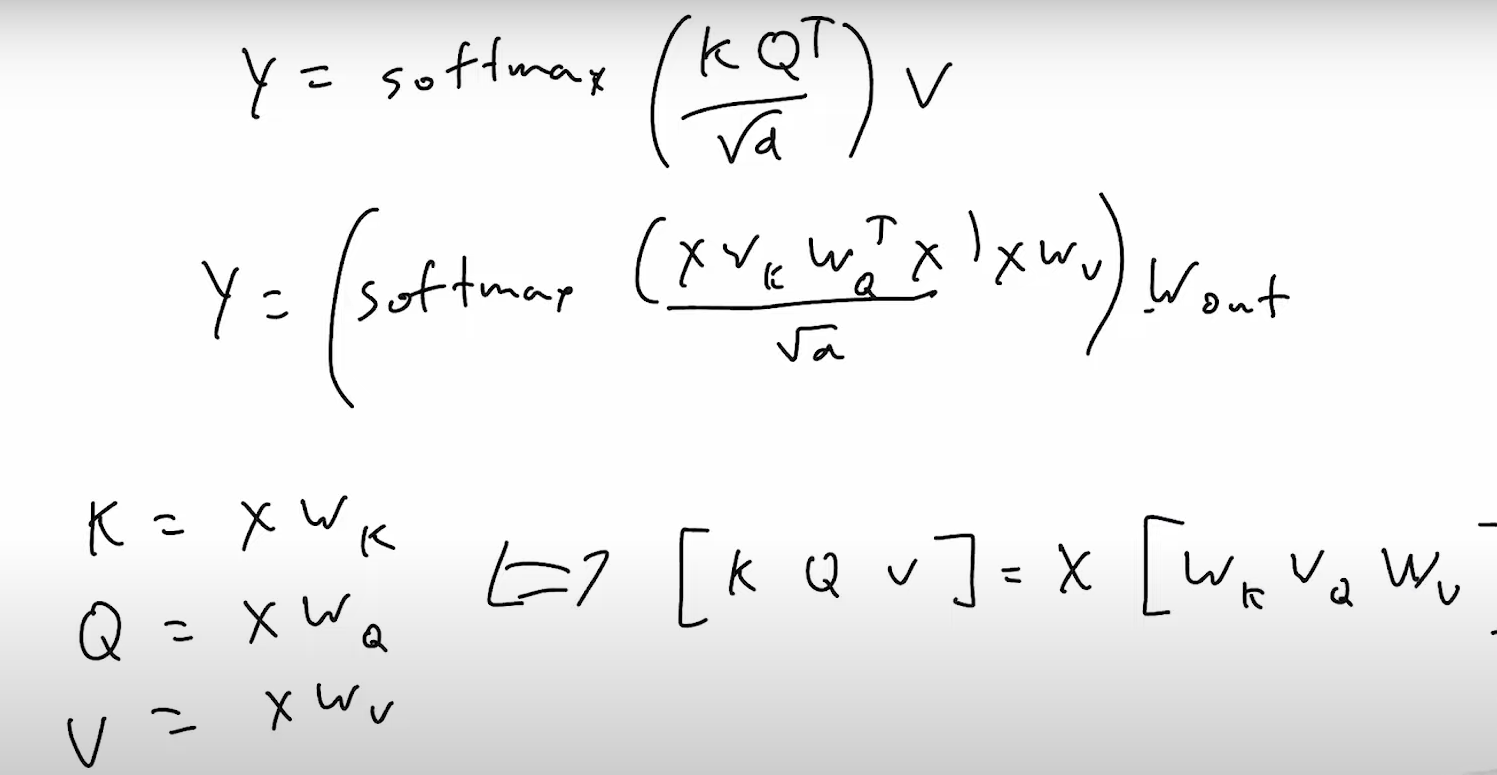

In [26]:
def softmax(Z):
    Z = np.exp(Z - Z.max(axis=-1, keepdims=True)) # keepdims=True will keep the dimensionality of the input same, 
    # see the cell below for example
    Z = Z/Z.sum(axis=-1, keepdims=True)

def self_attention(X, mask, W_KQV, W_out):
    K,Q,V = np.split(X@W_KQV, 3, axis=1)
    attn = softmax(K@Q.T / np.sqrt(X.shape[1]) + mask) # shape of X is T*d
    return attn@V@W_out, attn

#### keepdims

In [25]:
a = np.array([[1,5,3],[7,3,0]]).max(axis=-1, keepdims=True)
b = np.array([[1,5,3],[7,3,0]]).max(axis=-1)
print(a, b, sep=2*'\n')

[[5]
 [7]]

[5 7]


### Minibatching
Here we send a batch instead of a single embedding. Input size is (B,T,d) where B is the Batch. See the image below for the difference between RNN and Transformer in minibatch.

<img src=attachment:79113436-1e8d-4fe1-91e5-a456cd391893.png alt="Image" style="width:250px;height:100px; float:left">
We need a special Batch Multiplication Matrix (BMM) to handle it, thus we need to change the initial self_attention function to make sizes compatible
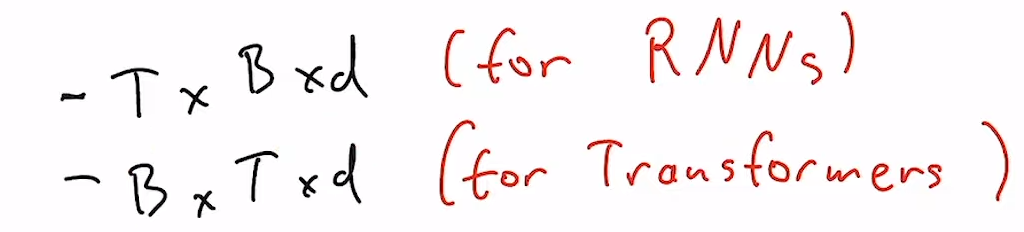

In [58]:
def self_attention(X, mask, W_KQV, W_out):
    K,Q,V = np.split(X@W_KQV, 3, axis=-1)
    attn = softmax(K@Q.swapaxes(-1,-2) / np.sqrt(X.shape[-1]) + mask) # swapaxes explained in the cell below
    return attn@V@W_out, attn

#### np.swapaxes
Transpose flips the dimension of an array; (2,5,3) becomes (3,5,2). What if we want to swap particular axes? We use np.swapaxes. So we can convert (2,5,3) to (5,2,3) using swapaxes(0,1), for example.

In [57]:
a = np.arange(0,30).reshape(2,5,3)
print(a, a.shape, a.swapaxes(0,1), a.swapaxes(0,1).shape, sep=2*'\n')

[[[ 0  1  2]
  [ 3  4  5]
  [ 6  7  8]
  [ 9 10 11]
  [12 13 14]]

 [[15 16 17]
  [18 19 20]
  [21 22 23]
  [24 25 26]
  [27 28 29]]]

(2, 5, 3)

[[[ 0  1  2]
  [15 16 17]]

 [[ 3  4  5]
  [18 19 20]]

 [[ 6  7  8]
  [21 22 23]]

 [[ 9 10 11]
  [24 25 26]]

 [[12 13 14]
  [27 28 29]]]

(5, 2, 3)


### Multihead attention

In [60]:
def multihead_attention(X, mask, heads, W_KQV, W_out):
    B,T,d = X.shape
    K,Q,V = np.split(X@W_KQV, 3, axis=-1)
    # B x T x d => B x heads x T x d/heads
    K,Q,V = [a.reshape(B, T, heads, d // heads).swapaxes(1,2) for a in (K,Q,V)]
    attn = softmax(K@Q.swapaxes(-1,-2) / np.sqrt(d // heads) + mask)
    return (attn@V).swapaxes(1,2).reshape(B,T,d) @ W_out, attn

### Transformer block
*Layer norm* = scale * (input - mean) / sqrt(variance + epsilon) + bias
- input: The original input tensor.
- mean: The mean along the feature dimension, calculated by averaging the values for each feature.
- variance: The variance along the feature dimension, calculated by averaging the squared differences from the mean for each feature.
- scale: A learnable parameter that rescales the normalized tensor.
- bias: A learnable parameter that shifts the normalized tensor.
- epsilon: A small constant added for numerical stability to avoid division by zero.

Layer normalization reduces the dependence of the model's performance on the scale of the activations and the specific data distribution. It also improves the flow of gradients during backpropagation

<img src=attachment:27610f26-09fd-426a-b2b4-44da7a892a61.png alt="Image" style="width:700px;height:150px; float:left">
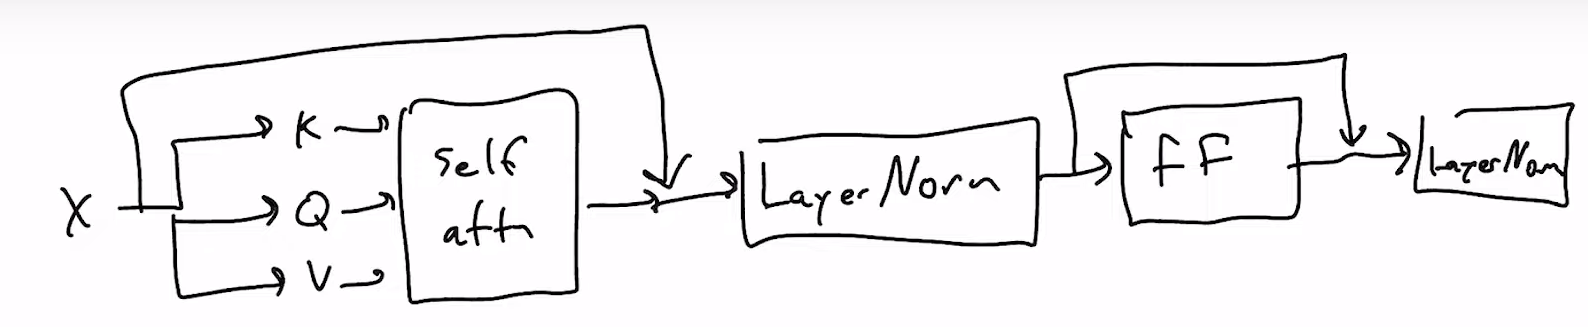

In [61]:
def layer_norm(Z, eps):
    return (Z - Z.mean(axis=-1, keepdims=True)) / np.sqrt(Z.var(axis=-1, keepdims=True) + eps)

def relu(Z):
    return np.maximum(Z,0)

def transformer(Z, mask, W_KQV, W_out, W_ff1, W_ff2, eps):
    Z = layer_norm(X + multihead_attention(X, mask, heads, W_KQV, W_out)[0], eps)
    return layer_norm(Z + relu(Z@W_ff1)@W_ff2, eps)